## MNIST classification with only numpy neural network

This task is from the great Coursera course <a href="https://www.coursera.org/learn/intro-to-deep-learning">Introduction to Deep Learning</a> by Higher School of Economics. <br>
"Build a neural network using naught but pure numpy and steel nerves"

In [1]:
import sys
import tqdm
from collections import Counter
import numpy as np
from IPython.display import clear_output

In [2]:
class Layer:
    """
    A building block. Has two functions for forward and backward steps.
    """
    def __init__(self):
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns the same
        """
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.     
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        """
        n_units = input.shape[1]
        d_layer_d_input = np.eye(n_units)
        return np.dot(grad_output, d_layer_d_input)

In [3]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        return np.maximum(input, np.zeros_like(input))
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad      

In [4]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.random.randn(output_units)*0.01
        
    def forward(self, input):
        """
        f(x) = xW + b
        """
        return input @ self.weights + self.biases
    
    def backward(self,input,grad_output):
        """
        Compute backward gradients
        """
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = grad_output @ self.weights.T
        
        # compute gradient w.r.t. weights and biases
        grad_weights = input.T @ grad_output
        grad_biases = np.sum(grad_output, axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [5]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [6]:
def load_dataset(flatten=False):
    """Load the MNIST dataset and preprocess it"""
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test
  

In [7]:
import keras 
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

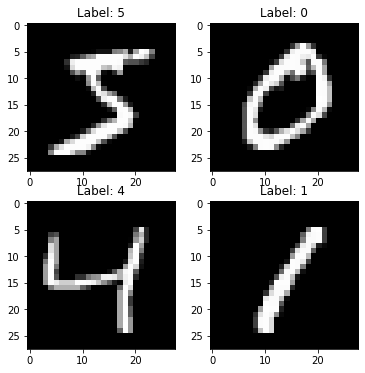

In [8]:
# Plot some examples
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [9]:
# create the ANN
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [10]:
network

In [11]:
# two steps for all network
def forward(network, X):
    """
    Compute activations of all network layers.
    """
    activations = []
    input = X
    for i in range(len(network)):
        z = network[i].forward(input)
        activations.append(z)
        input = z
        
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train the network on a given batch of X and y.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    for i in reversed(range(len(network))):
        loss_grad = network[i].backward(layer_inputs[i], loss_grad)
    return np.mean(loss)

In [12]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    """Create batches for training"""
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Epoch 11
Train accuracy: 0.99614
Val accuracy: 0.9768


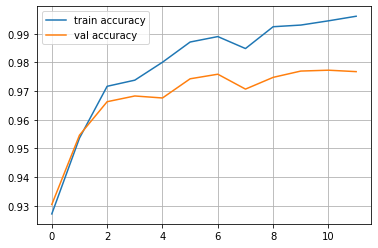

In [13]:
train_log = []
val_log = []

for epoch in range(12):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)

    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

### Xavier Init

In [14]:
class Dense_Xavier(Dense):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer with the Xavier initialization
        """
        self.learning_rate = learning_rate
        
        self.weights = np.random.normal(loc=0, 
                                        scale=np.sqrt(2/(input_units+output_units)),
                                        size=(input_units, output_units))
        self.biases = np.random.normal(loc=0, 
                                       scale=np.sqrt(2/(input_units+output_units)),
                                       size=(output_units,))

Epoch 11
Train accuracy: 0.99682
Val accuracy: 0.9793


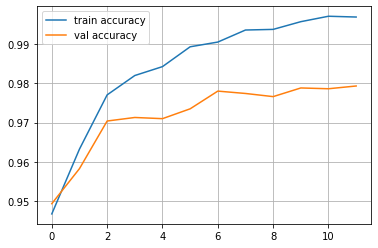

In [15]:
train_log_Xavier = []
val_log_Xavier = []
# the same network except init.
network = []
network.append(Dense_Xavier(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense_Xavier(100,200))
network.append(ReLU())
network.append(Dense_Xavier(200,10))
for epoch in range(12):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)

    
    train_log_Xavier.append(np.mean(predict(network,X_train)==y_train))
    val_log_Xavier.append(np.mean(predict(network,X_val)==y_val))
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log_Xavier[-1])
    print("Val accuracy:",val_log_Xavier[-1])
    plt.plot(train_log_Xavier,label='train accuracy')
    plt.plot(val_log_Xavier,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

### Comparing the default initialization and the Xavier Init

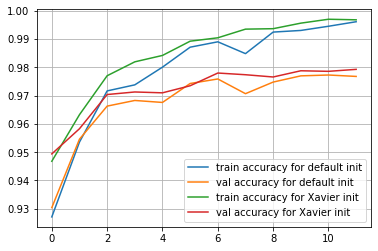

In [16]:
plt.plot(train_log,label='train accuracy for default init')
plt.plot(val_log,label='val accuracy for default init')
plt.plot(train_log_Xavier,label='train accuracy for Xavier init')
plt.plot(val_log_Xavier,label='val accuracy for Xavier init')
plt.legend(loc='best')
plt.grid()
plt.show()

In [17]:
# The same network with Xavier init converges faster than the network with dafault init